<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/325_metropolis.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>


(metropolis_notebook)=
# Monte Carlo a Catena di Markov

In precedenza, abbiamo esplorato diversi esempi di inferenza bayesiana relativi alla distribuzione a posteriori di un singolo parametro, come nel caso del modello bernoulliano. Abbiamo anche discusso l'utilizzo di approcci come l'approssimazione tramite griglia e i metodi dei priori coniugati per ottenere o approssimare la distribuzione a posteriori.

In questo capitolo, ci concentreremo sul metodo di simulazione e spiegheremo perché sono necessari approcci speciali noti come metodi di Monte Carlo a Catena di Markov (MCMC).

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
import arviz as az

In [52]:
%config InlineBackend.figure_format = 'retina'

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

from aquarel import load_theme
theme = load_theme("minimal_light")
theme.apply()
import matplotlib.style as style 
style.use("tableau-colorblind10")

## Il denominatore bayesiano

Nel contesto dell'approccio bayesiano, il nostro obiettivo primario è ottenere la distribuzione a posteriori di un parametro $\theta$, facendo affidamento sui dati osservati $y$ e sulla distribuzione a priori $p(\theta)$. Tale distribuzione viene derivata applicando il teorema di Bayes:

$$
p(\theta \mid y) = \frac{p(y \mid \theta) p(\theta)}{p(y)}.
$$

Tuttavia, il calcolo dell'evidenza $p(y)$ può rivelarsi complesso e non sempre ottenibile in modo analitico, specialmente quando si tratta di modelli complessi. Questa sfida può ostacolare l'ottenimento preciso della distribuzione a posteriori.

Le distribuzioni a priori coniugate offrono un approccio analitico per calcolare la distribuzione a posteriori, ma ciò comporta una limitazione nella scelta delle distribuzioni a priori e di verosimiglianza. Per modelli più intricati, in cui i metodi di campionamento a griglia risultano inapplicabili, entrano in gioco i Metodi di Catena di Markov a Monte Carlo (MCMC), che rappresentano una potente alternativa per ottenere la distribuzione a posteriori. Questi metodi consentono di ricavare la distribuzione a posteriori basandosi su presupposti teorici, senza restrizioni sulla selezione delle distribuzioni a priori o delle verosimiglianze.

L'approccio Monte Carlo impiega sequenze di numeri casuali opportunamente generati per creare un ampio campione di osservazioni proveniente dalla distribuzione a posteriori. A seguire, le proprietà di interesse possono essere stimate empiricamente basandosi su tale campione.

Nel complesso, il calcolo della distribuzione a posteriori all'interno di un contesto bayesiano richiede l'uso di metodi computazionalmente intensivi, spesso eseguibili solo tramite software specializzato. Tuttavia, grazie alla crescente potenza di calcolo dei computer negli ultimi anni, i metodi bayesiani per l'analisi dei dati stanno guadagnando popolarità, poiché tali calcoli sono ora accessibili a tutti.

## Il Metodo di Monte Carlo

Il Metodo di Monte Carlo rappresenta un approccio numerico che fa uso di numeri casuali per ottenere approssimazioni a problemi complessi, specialmente quando i calcoli analitici risultano difficili o impossibili. L'idea fondamentale di questo metodo è generare un'ampia serie di punti casuali e utilizzarli per stimare quantità di interesse. Un esempio comune è l'integrazione numerica, in cui si approssimano integrali complessi calcolando la media dei valori di una funzione calcolata su punti casuali all'interno di un dominio specifico.

Per chiarire questo concetto, possiamo considerare la distribuzione continua $p(\theta \mid y)$ con media $\mu$. Se riusciamo ad ottenere una sequenza di campioni casuali $\theta^{(1)}, \theta^{(2)}, \dots, \theta^{(T)}$ indipendenti e identicamente distribuiti da $p(\theta \mid y)$, possiamo stimare l'aspettativa teorica di $\theta$ mediante la media campionaria $\frac{1}{T} \sum_{i=1}^T \theta^{(t)}$. Questa approssimazione diventa sempre più accurata all'aumentare del numero di campioni $T$, grazie alla Legge Forte dei Grandi Numeri.

In aggiunta, il Metodo di Monte Carlo può essere impiegato per approssimare la probabilità che una variabile casuale $\theta$ cada all'interno di un intervallo specifico $(l, u)$. Ciò è realizzabile calcolando la media campionaria del valore della funzione indicatrice $I(l < \theta < u)$ per ogni realizzazione $\theta^{(t)}$, ovvero $Pr(l < \theta < u) \approx \frac{\text{numero di realizzazioni } \theta^{(t)} \in (l, u)}{T}$.

All'interno dell'analisi bayesiana, il Metodo di Monte Carlo viene impiegato per ottenere un'approssimazione della distribuzione a posteriori $p(\theta \mid y)$, soprattutto quando tale distribuzione non può essere calcolata mediante metodi analitici. In altre parole, il Metodo di Monte Carlo ci consente di generare un grande insieme di valori per $\theta$, che idealmente seguiranno la medesima distribuzione della distribuzione a posteriori $p(\theta \mid y)$.

In conclusione, il Metodo di Monte Carlo costituisce una potente risorsa numerica, basata sulla generazione di numeri casuali, che ci permette di ottenere approssimazioni in contesti complessi. Tale metodo risulta particolarmente utile per stimare aspettative e probabilità quando i calcoli analitici risultano difficoltosi o irrealizzabili. L'accuratezza dell'approssimazione migliora in proporzione all'aumento dei campioni utilizzati. Nell'analisi bayesiana, il Metodo di Monte Carlo trova un'ampia applicazione nell'approssimazione della distribuzione a posteriori.

## Le catene di Markov 

Le catene di Markov furono introdotte per la prima volta nel 1906 da Andrey Markov. L'obiettivo principale era di estendere la legge dei grandi numeri a variabili casuali che non sono indipendenti. Tradizionalmente, in statistica si lavora con sequenze di variabili casuali indipendenti e identicamente distribuite (i.i.d.), denotate come $X_0, X_1, \ldots, X_n, \ldots$, dove $n$ è un indice temporale discreto. Questo approccio è adeguato quando si presume l'indipendenza completa tra le variabili casuali. Tuttavia, tale assunzione spesso non è realistica per modellare fenomeni complessi, rendendo necessario esplorare altre forme di dipendenza.

### La proprietà di Markov e la dipendenza a un passo

Per affrontare queste limitazioni, le catene di Markov introducono una "dipendenza a un passo", codificata nella "proprietà di Markov". Secondo questa proprietà, la previsione di una variabile futura $X_{n+1}$ è condizionata solo dal termine più recente $X_n$, indipendentemente dalla storia passata $X_0, X_1, X_2, \ldots, X_{n-1}$. Matematicamente, la proprietà di Markov è espressa come:

$$
P(X_{n+1} = j | X_n = i, X_{n-1} = i_{n-1}, \ldots, X_0 = i_0) = P(X_{n+1} = j | X_n = i).
$$

Questa formalizzazione consente una notevole semplificazione nei calcoli di probabilità condizionale.

### Spazio degli stati e dinamica del processo

Le variabili casuali in una catena di Markov vivono in un "spazio degli stati", che può essere sia discreto che continuo. Nel nostro contesto, ci concentreremo su catene con spazio degli stati discreto e finito, denotato generalmente come $\{1, 2, \ldots, M\}$.

La dinamica delle catene di Markov è descritta attraverso "probabilità di transizione" tra gli stati, che possono essere codificate in una "matrice di transizione". Ogni elemento $ (i, j) $ di questa matrice rappresenta la probabilità di passare dallo stato $ i $ al stato $ j $ in un passaggio della catena.

### Applicazioni pratiche: Metropolis e MCMC

Le catene di Markov trovano applicazione nell'algoritmo di Metropolis attraverso un framework noto come Markov Chain Monte Carlo (MCMC). MCMC sfrutta la natura dipendente delle catene di Markov per navigare efficacemente nello spazio delle soluzioni di una distribuzione a posteriori, soprattutto quando un'analisi analitica è impraticabile. In questo modo, il MCMC si dimostra un potente strumento per risolvere problemi complessi dove metodi analitici tradizionali falliscono.

In sintesi, le catene di Markov forniscono un framework robusto e flessibile per modellare dipendenze tra variabili casuali, rendendole strumenti fondamentali in diversi ambiti della statistica e della scienza dei dati, inclusa la metodologia MCMC utilizzata in algoritmi come Metropolis.

```{admonition} Terminologia
:class: tip

**Catene di Markov omogenee**

Una catena di Markov è detta "omogenea" quando le probabilità di transizione tra gli stati sono indipendenti dal tempo. In termini più semplici, la dinamica della catena è regolata da una matrice di transizione fissa che rimane costante nel tempo. Ciò significa che la probabilità di passare da uno stato all'altro è sempre la stessa, indipendentemente dal momento in cui avviene questa transizione.

**Catene di Markov irriducibili**

Una catena di Markov è "irriducibile" quando è possibile raggiungere qualsiasi stato partendo da qualsiasi altro stato in un numero finito di passaggi. In altre parole, non esistono stati isolati che intrappolano la catena indefinitamente. 

**Stati ricorrenti**

In una catena di Markov, uno stato è considerato "ricorrente" se viene rivisitato ripetutamente. Gli stati possono ulteriormente essere classificati come "positivamente ricorrenti" se esiste un tempo limitato per tornare allo stato, e "nullamente ricorrenti" in caso contrario. Gli stati "ricorrenti di Harris" sono quelli che vengono visitati infinite volte mentre il tempo tende all'infinito.

**Aperiodicità**

Gli stati "aperiodici" in una catena di Markov sono quelli senza cicli deterministici, il che significa che la catena non rimane bloccata in un ciclo fisso di stati. 

**Stazionarietà**

Nella teoria delle catene di Markov, la "distribuzione marginale" è semplicemente la distribuzione delle probabilità degli stati della catena in un certo momento. In altre parole, è una descrizione delle probabilità di trovarsi in ciascuno degli stati possibili in un determinato istante di tempo. Se stiamo parlando, ad esempio, di una catena di Markov con tre stati (A, B, C), una possibile distribuzione marginale potrebbe essere $[0.4, 0.5, 0.1]$, indicando che la probabilità di trovarsi nello stato A è del 40%, nello stato B del 50% e nello stato C del 10%.

Una catena di Markov è definita come "stazionaria" quando questa distribuzione marginale rimane invariata nel tempo. In altre parole, le probabilità di essere in ogni stato possibile non cambiano, anche se la catena passa da uno stato all'altro seguendo le probabilità di transizione.

La stazionarietà è un concetto cruciale perché rende possibile analizzare il comportamento a lungo termine della catena senza dover tener conto di tutti i dettagli delle transizioni individuali. In pratica, una volta che la catena è stazionaria, sappiamo che la sua distribuzione marginale non cambierà più, e questo è spesso ciò che ci interessa nelle applicazioni reali.

**Ergodicità**

L'ergodicità è un'altra proprietà fondamentale che descrive come una catena di Markov si comporta nel limite quando il numero di passaggi tende all'infinito. Una catena ergodica è una catena che è sia aperiodica (non ha cicli fissi) sia irriducibile (ogni stato è raggiungibile da ogni altro stato) e positivamente ricorrente secondo Harris (ogni stato viene visitato infinite volte in un tempo finito). Ciò significa che mentre il numero di passaggi tende all'infinito, la distribuzione marginale della catena rimane stabile. Pertanto, se campioniamo da una catena di Markov stazionaria a intervalli ampiamente distanziati, questi campioni possono essere considerati indipendenti.

Nella teoria ergodica, si discute spesso di "burn-in", che è il periodo di tempo necessario perché la catena si avvicini alla distribuzione stazionaria, e di "thinning", che è la pratica di prendere campioni a intervalli ampiamente distanziati per minimizzare la correlazione tra i campioni.  

**Convergenza**

Nel contesto della convergenza, le proprietà di irriducibilità e aperiodicità garantiscono che la catena di Markov si stabilizzerà in un equilibrio a lungo termine, specificamente convergendo verso una distribuzione stazionaria $ s $. In questo scenario, "convergenza" implica che con l'incrementare indefinito del numero di passaggi $ n $, la distribuzione marginale della catena tende sempre più verso la distribuzione stazionaria $ s $.

Tale convergenza è di natura probabilistica e avviene a prescindere dalle condizioni iniziali, cioè dall'effettivo stato da cui la catena è partita. Detto in modo più semplice, con un tempo sufficientemente lungo, il comportamento della catena di Markov diventa prevedibile e stabile, in accordo con la distribuzione stazionaria $ s $.

Quindi, i concetti di convergenza e stazionarietà sono strettamente correlati: la convergenza rappresenta il percorso che la catena percorre per raggiungere uno stato di equilibrio, mentre la stazionarietà fornisce una descrizione formale di questo stato di equilibrio al quale la catena tenderà nel lungo periodo.

```

## Catene di Markov Monte Carlo

Nei capitoli precedenti della dispensa abbiamo sottolineato l'importanza della simulazione come strumento efficace nel campo della probabilità. A titolo di esempio, consideriamo il problema di Monty Hall: simulando il gioco numerosissime volte, è facile accorgersi che la probabilità di vittoria sale a circa 2/3 se si decide di cambiare porta. Allo stesso modo, quando non è chiaro come calcolare statistiche come la media e la varianza di una variabile casuale $X$, ma si è in grado di generare campioni indipendenti e identicamente distribuiti $X_1, X_2, \ldots, X_n$ da tale distribuzione, è possibile ricorrere alla media e alla varianza campionaria come approssimazioni valide:

$$
\text{E}(X) \approx \frac{1}{n} (X_1 + \ldots + X_n) = \bar{X}_n
$$
$$
\text{Var}(X) \approx \frac{1}{n - 1} \sum_{j=1}^{n} (X_j - \bar{X}_n)^2
$$

La legge dei grandi numeri ci assicura che tali stime diventeranno sempre più accurate man mano che $n$ aumenta. Questo significa che, incrementando il numero delle simulazioni, possiamo ottenere stime più precise senza dover affrontare il calcolo di somme o integrali complicati. Questa metodologia è parte di quella che è conosciuta come metodo Monte Carlo.

Tuttavia, un limite rilevante dei metodi Monte Carlo tradizionali è la necessità di sapere come generare in modo efficiente i campioni $X_1, X_2, \ldots, X_n$, soprattutto se si mira a un $n$ elevato.

In questo contesto, i metodi di Monte Carlo basati su catene di Markov (MCMC) rappresentano un insieme di algoritmi potenti che ci consentono di effettuare simulazioni da distribuzioni complesse utilizzando catene di Markov. L'evoluzione degli algoritmi MCMC ha rivoluzionato la statistica e il calcolo scientifico, ampliando enormemente il ventaglio delle distribuzioni simulabili, inclusi gli spazi di alta dimensionalità. In questo capitolo, ci concentreremo su uno degli algoritmi MCMC più importanti e comunemente usati: l'algoritmo di Metropolis.

## Estrazione di campioni dalla distribuzione a posteriori

L'obiettivo primario è di comprendere come utilizzare l'algoritmo di Metropolis per approssimare la distribuzione a posteriori $p(\theta \mid y)$. A questo fine, il capitolo è strutturato in varie sezioni che facilitano la comprensione progressiva del tema. 

- Inizieremo discutendo di come la distribuzione a posteriori possa essere approssimata mediante tecniche di simulazione convenzionali. Questa prima parte presuppone che la distribuzione target, o "a posteriori," sia già conosciuta o disponibile per l'analisi.
- In seguito, passeremo a illustrare come l'algoritmo di Metropolis possa essere utilizzato per raggiungere lo stesso scopo—l'approssimazione della distribuzione a posteriori—mantenendo la presupposizione che la distribuzione target sia già nota.
- Concluderemo il capitolo esplorando le modalità con cui l'algoritmo di Metropolis può essere adattato per affrontare situazioni in cui la distribuzione a posteriori non è direttamente nota. In questi casi, spesso abbiamo a disposizione informazioni riguardanti la distribuzione a priori e la funzione di verosimiglianza, che possono essere utilizzate per ottenere un'approssimazione efficace della distribuzione a posteriori.

A titolo esemplificativo, utilizzeremo il dataset `moma_sample.csv`, il quale costituisce un campione casuale di 100 artisti provenienti dal Museo di Arte Moderna di New York (MoMA) e contiene diverse informazioni relative a ciascun artista.

Il nostro interesse è focalizzato sulla determinazione della probabilità che un artista presente nel MoMA appartenga alla generazione X o a una generazione successiva (nati dopo il 1965). Questa probabilità sarà indicata come $\pi$. Iniziamo importando i dati.

In [31]:
moma_sample = pd.read_csv("../data/moma_sample.csv")

Esaminiamo le prime cinque righe del DataFrame.

In [32]:
moma_sample.head()

,artist,country,birth,death,alive,genx,gender,count,year_acquired_min,year_acquired_max
0,Ad Gerritsen,dutch,1940,2015.0,False,False,male,1,1981,1981
1,Kirstine Roepstorff,danish,1972,NaN,True,True,female,3,2005,2005
2,Lisa Baumgardner,american,1958,2015.0,False,False,female,2,2016,2016
3,David Bates,american,1952,NaN,True,False,male,1,2001,2001
4,Simon Levy,american,1946,NaN,True,False,male,1,2012,2012


Dai dati osserviamo che solo 14 artisti su 100 appartengono alla generazione X o a una generazione successiva.

In [33]:
result = moma_sample["genx"].value_counts()
print(result)

genx
False    86
True     14
Name: count, dtype: int64


Il valore campionato $y = 14$ riflette le caratteristiche del campione che è stato osservato. Tuttavia, poiché il MOMA contiene opere di migliaia di artisti, sorge una domanda riguardante il vero valore di $\theta$ (la probabilità di appartenere alla generazione X o a una generazione successiva) all'interno di questa popolazione.

Possiamo interpretare i dati $y = 14$ come l'esito di una variabile casuale Binomiale con parametri $N = 100$ e $\theta$ sconosciuto.

Supponiamo che le nostre credenze pregresse riguardo a $\theta$ possano essere modellate attraverso una distribuzione Beta(4, 6).

Sfruttando le proprietà delle distribuzioni coniugate, possiamo calcolare la distribuzione a posteriori esatta:

```python
Y ~ Binomiale(100, π)
θ = Beta(4, 6)
θ | (Y = 14) ~ Beta(4 + 14, 6 + 100 - 14) → Beta(18, 92)
```

Nella figura successiva è rappresentata la distribuzione a posteriori del parametro $\theta$, insieme alla distribuzione a priori scelta.

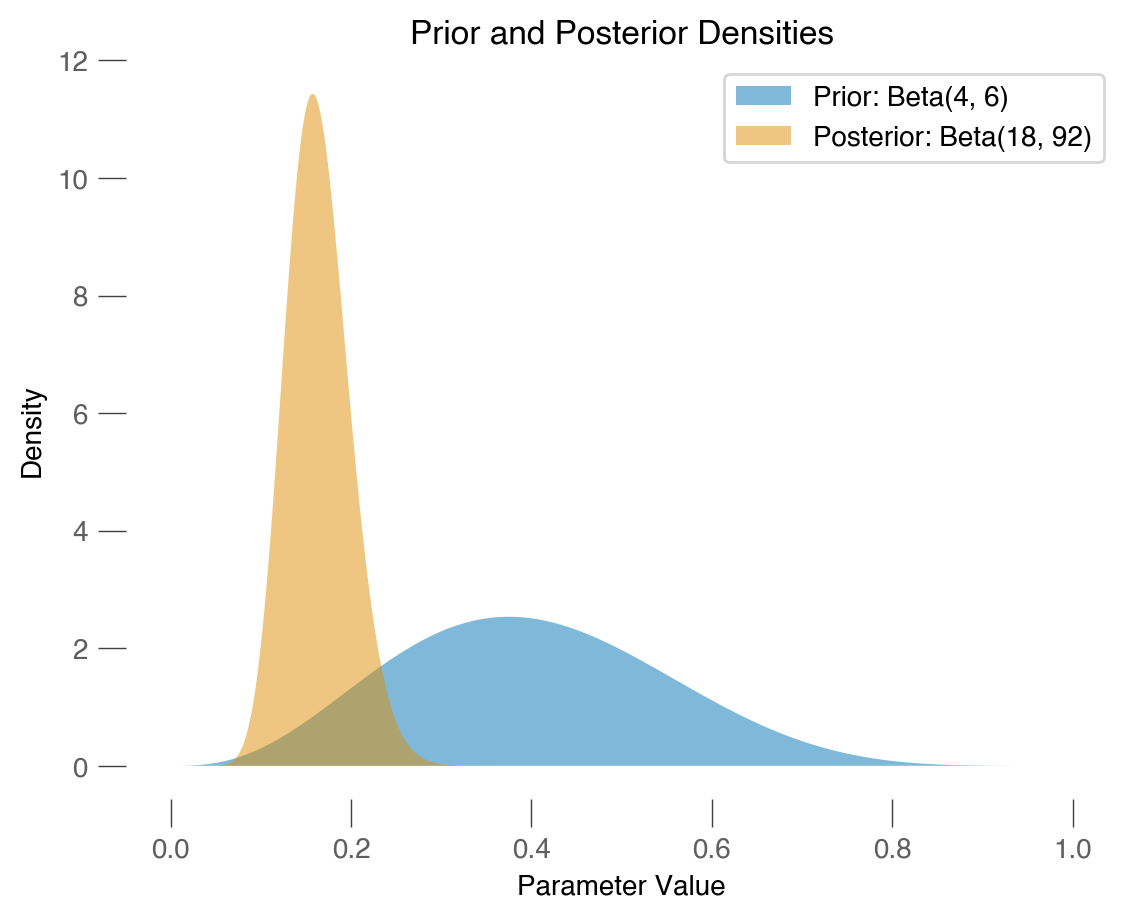

In [6]:
x = np.linspace(0, 1, 1000)

prior_density = stats.beta.pdf(x, 4, 6)
posterior_density = stats.beta.pdf(x, 18, 92)

plt.fill_between(x, prior_density, alpha=0.5, label="Prior: Beta(4, 6)")
plt.fill_between(x, posterior_density, alpha=0.5, label="Posterior: Beta(18, 92)")
plt.xlabel("Parameter Value")
plt.ylabel("Density")
plt.legend()
plt.title("Prior and Posterior Densities")
plt.show()

Se vogliamo conoscere il valore della media a posteriori di $\theta$, il risultato esatto è

$$
\bar{\theta}_{post} = \frac{\alpha}{\alpha + \beta} = \frac{18}{18 + 92} \approx 0.1636.
$$

### Simulazione con distribuzione target nota

Usiamo ora una simulazione numerica per stimare la media a posteriori di $\theta$. Conoscendo la forma della distribuzione a posteriori $Beta(18, 92)$, possiamo generare un campione di osservazioni casuali da questa distribuzione. Successivamente, calcoliamo la media delle osservazioni ottenute per ottenere un'approssimazione della media a posteriori.

Se vogliamo ottenere un risultato approssimato con poche osservazioni (ad esempio, 10), possiamo procedere con la seguente simulazione:

In [20]:
y = stats.beta(18, 92).rvs(10)
print(*y)

0.1533798664453532 0.14582961759217178 0.17051024631307674 0.1626680821402494 0.18402410951832873 0.17200651913310616 0.1889769603274472 0.16181120921247916 0.19000037696483082 0.11445573118445253


In [21]:
y.mean()

0.16436627188314956

Tuttavia, con solo 10 campioni l'approssimazione potrebbe non essere molto accurata. Più aumentiamo il numero di campioni (cioè il numero di osservazioni casuali generate), più precisa sarà l'approssimazione. Aumentando il numero di campioni, ad esempio a 10000, otteniamo un risultato più preciso:

In [22]:
stats.beta(18, 92).rvs(10000).mean()

0.16375090324507724

Quando il numero di campioni a posteriori diventa molto grande, la distribuzione campionaria *converge* alla densità della popolazione. Questo concetto si applica non solo alla media, ma anche ad altre statistiche descrittive, come la moda e la varianza.

È importante sottolineare che l'applicazione della simulazione di Monte Carlo è efficace per calcolare distribuzioni a posteriori solo quando conosciamo la distribuzione stessa e possiamo utilizzare funzioni Python per estrarre campioni casuali da tale distribuzione. Ciò è stato possibile nel caso della distribuzione a posteriori $Beta(18, 92)$. 

Tuttavia, questa situazione ideale non si verifica sempre nella pratica, poiché le distribuzioni a priori coniugate alla verosimiglianza sono spesso rare. Per esempio, nel caso di una verosimiglianza binomiale e una distribuzione a priori gaussiana, l'espressione

$$
p(\theta \mid y) = \frac{\mathrm{e}^{-(\theta - 1 / 2)^2} \theta^y (1 - \theta)^{n - y}} {\int_0^1 \mathrm{e}^{-(t - 1 / 2)^2} t^y (1 - t)^{n - y} dt}
$$

rende impossibile calcolare analiticamente la distribuzione a posteriori di $\theta$, precludendo quindi l'utilizzo diretto di Python per generare campioni casuali.

In queste circostanze, però, è possibile ottenere campioni casuali dalla distribuzione a posteriori mediante l'uso di metodi Monte Carlo basati su Catena di Markov (MCMC). Gli algoritmi MCMC, come ad esempio l'algoritmo Metropolis, costituiscono una classe di metodi che consentono di estrarre campioni casuali dalla distribuzione a posteriori *senza richiedere la conoscenza della sua rappresentazione analitica*. Le tecniche MCMC sono ampiamente adottate per risolvere problemi di inferenza bayesiana e rappresentano il principale strumento computazionale per ottenere stime approssimate di distribuzioni a posteriori in situazioni complesse e non analiticamente trattabili.

## Algoritmo di Metropolis

Gli algoritmi MCMC vengono utilizzati per campionare la distribuzione a posteriori attraverso l'applicazione di un processo di catena di Markov. Questi algoritmi fondono tecniche di campionamento di tipo "Monte Carlo" con meccanismi di transizione "a salti" intelligenti, che sono indipendenti dalla posizione iniziale. Questo approccio permette di effettuare campionamenti "senza memoria," utilizzando salti intelligenti per evitare distorsioni sistematiche nei campioni ottenuti.

L'esempio più famoso di algoritmo MCMC è l'algoritmo di Metropolis, proposto per la prima volta nel 1953 {cite:p}`metropolist_etal_1953`. Questo algoritmo segue lo schema seguente:

1. Si utilizza una distribuzione proposta per suggerire un possibile salto.
2. Si calcola successivamente la densità di probabilità (pdf) nello stato corrente e la si confronta con quella del passo precedente.
3. Se la probabilità è aumentata, si accetta il salto. Se la probabilità è diminuita, si accetta il salto solo in alcuni casi, in base al rapporto tra la nuova e la vecchia probabilità.
4. Si accumulano i campioni, poiché l'obiettivo è quello di campionare una specifica distribuzione.

L'uso di salti intelligenti e l'accettazione o il rifiuto probabilistico dei salti consentono all'algoritmo di Metropolis e agli algoritmi MCMC in generale di esplorare in modo efficiente lo spazio dei parametri e di fornire campioni rappresentativi della distribuzione a posteriori desiderata.

In questo [post](https://elevanth.org/blog/2017/11/28/build-a-better-markov-chain/), è possibile osservare una rappresentazione grafica del processo di "esplorazione" dello spazio dei parametri effettuata dall'algoritmo di Metropolis. La principale differenza tra i vari algoritmi MCMC risiede nel modo in cui vengono effettuati i salti e nel criterio utilizzato per decidere se accettare o rifiutare un salto.

Per fornire un esempio pratico, ritorniamo al caso precedentemente discusso in cui la distribuzione a posteriori è una Beta(18, 92). Utilizzeremo l'algoritmo di Metropolis per generare campioni da questa distribuzione nota.

Iniziamo definendo la distribuzione da cui verranno proposti i nuovi campioni. In questo primo esempio, optiamo per la distribuzione proposta più semplice: una variazione minima, estratta da una distribuzione uniforme, che verrà aggiunta al valore del campione precedente.

Ora descriviamo l'implementazione dell'algoritmo di Metropolis.

In [34]:
# Proposal distribution
def uniprop(xprev, delta=0.05):
    return xprev + stats.uniform.rvs(loc=-delta, scale=2 * delta)

In [8]:
# Metropolis algorithm 
def metropolis_v1(p, qdraw, nsamp, xinit):
    """
    Implements the Metropolis algorithm for MCMC sampling.

    The function generates `nsamp` samples from a target distribution `p` using 
    the Metropolis algorithm. The algorithm starts with an initial state `xinit` 
    and iteratively applies a proposal mechanism governed by `qdraw` to explore 
    the target distribution.

    Args:
        p (callable): A function representing the target distribution to sample from.
                     Should accept a float or array-like and return the density 
                     (unnormalized is okay) at that point.
                     
        qdraw (callable): A function implementing the proposal mechanism. 
                          Takes the current state (float or array-like) as input 
                          and returns a proposed next state.
                          
        nsamp (int): The number of samples to draw from the target distribution.
        
        xinit (float or array-like): The initial state for the MCMC chain.

    Returns:
        numpy.ndarray: An array of shape (nsamp,) containing samples drawn from the 
        target distribution `p`.

    Example:
        >>> import numpy as np
        >>> from scipy import stats
        >>> target = stats.norm().pdf  # Standard Normal as target
        >>> qdraw = lambda x: x + np.random.normal(0, 1)  # Random-walk Metropolis
        >>> samples = metropolis_v1(target, qdraw, 10000, 0.0)
    """
    samples = np.empty(nsamp)
    x_prev = xinit
    for i in range(nsamp):
        x_star = qdraw(x_prev)
        p_star = p(x_star)
        p_prev = p(x_prev)
        pdfratio = p_star / p_prev
        if np.random.uniform() < min(1, pdfratio):
            samples[i] = x_star
            x_prev = x_star
        else:
            samples[i] = x_prev
    return samples

### Sintassi della funzione

```python
def metropolis_v1(p, qdraw, nsamp, xinit):
```

#### Parametri
1. `p`: Questa è la distribuzione target da cui si desidera campionare. È fornita come una funzione invocabile che prende un valore `x` e restituisce la densità di probabilità (o massa) in quel punto. La distribuzione target potrebbe anche non essere normalizzata.

2. `qdraw`: Questa è la distribuzione proposta da cui viene generato un possibile stato successivo (`x_star`), dato lo stato corrente (`x_prev`). Anche questa è una funzione invocabile, che dovrebbe restituire una nuova proposta basata sullo stato corrente.

3. `nsamp`: Questo è il numero di campioni che si desidera generare dalla distribuzione target. Determina quante iterazioni verranno eseguite dall'algoritmo.

4. `xinit`: Questo è lo stato iniziale della catena di Markov. L'algoritmo partirà da questo punto.

#### Valore di ritorno

- La funzione restituisce un array (`samples`) di dimensione `nsamp`, contenente i campioni estratti dalla distribuzione target.

### Dettagli dell'algoritmo

1. **Inizializzazione**: 
```python
samples = np.empty(nsamp)
x_prev = xinit
```
  - `samples`: Un array NumPy vuoto che sarà popolato con i campioni generati dall'algoritmo.
  - `x_prev`: Lo stato corrente della catena di Markov. Inizializzato a `xinit`. Iniziamo dunque con un punto arbitrario nello spazio dei parametri. Questo primo valore della catena di Markov può essere scelto casualmente tra i valori possibili del parametro.

2. **Il ciclo**: 
```python
for i in range(nsamp):
```
   - Si itera `nsamp` volte per generare `nsamp` campioni.
   
3. **Fase di proposta**: 
```python
x_star = qdraw(x_prev)
```
   - Un nuovo stato (`x_star`) viene proposto sulla base dello stato corrente (`x_prev`) utilizzando la funzione di distribuzione proposta `qdraw`.

4. **Calcolo della densità**: 
```python
p_star = p(x_star)
p_prev = p(x_prev)
```
   - Calcola le densità dei punti proposti (`x_star`) e correnti (`x_prev`) utilizzando la funzione di distribuzione target `p`.

5. **Rapporto tra densità**: 
```python
pdfratio = p_star / p_prev
```
   - Viene calcolato il rapporto tra le densità (`p_star / p_prev`). Questo rapporto decide se accettare o meno lo stato proposto.

6. **Fase di accettazione**: 
```python
if np.random.uniform() < min(1, pdfratio):
    samples[i] = x_star
    x_prev = x_star
else:
    samples[i] = x_prev
```
   - Viene estratto un numero casuale dalla distribuzione uniforme tra 0 e 1.
   - Se questo numero è minore del minimo tra 1 e `pdfratio`, lo stato proposto viene accettato e `x_prev` viene aggiornato a `x_star`.
   - Altrimenti, lo stato proposto viene respinto e lo stato corrente (`x_prev`) viene mantenuto per il ciclo successivo.

   In sintesi, la decisione di accettare o rifiutare il parametro proposto `x_star` si basa sul valore di `pdfratio`. Se `pdfratio` è maggiore di 1, ciò indica che il parametro proposto è più probabile del parametro corrente `x_prev`; di conseguenza, `x_star` viene sempre accettato. Se, invece, `pdfratio` è minore di 1, il parametro proposto viene accettato con una probabilità che è proporzionale a `pdfratio` stesso. Per esempio, un `pdfratio` di 0.10 implica una probabilità del 10% di accettare `x_star`.

   Questa strategia di accettazione ci consente di generare campioni che sono statisticamente rappresentativi della distribuzione target. Questo perché la probabilità di accettare un candidato è direttamente proporzionale alla sua densità della distribuzione che stiamo cercando di campionare.

   Nella pratica, questo processo decisionale viene implementato confrontando `pdfratio` con un numero casuale $u$, estratto da una distribuzione uniforme $Unif(0, 1)$. Se `pdfratio` $> u$, il parametro proposto `x_star` viene accettato, e la catena di Markov si sposta verso questo nuovo valore. In caso contrario, il valore corrente `x_prev` viene mantenuto come prossimo elemento nella catena.


### Algoritmo di Metropolis con distribuzione target nota

Applichiamo ora l'algoritmo di Metropolis usando una Beta(18, 92) quale distribuzione target e una distribuzione uniforme quale distribuzione proposta.

In [35]:
# Initialization
init_state = 0.5
n_samples = 100000

In [53]:
# Using Beta(18, 92) as the target distribution
samps = metropolis_v1(lambda x: stats.beta.pdf(x, 18, 92), uniprop, n_samples, init_state)

```{note}
La ragione per cui è necessario scrivere `lambda x: stats.beta.pdf(x, 18, 92)` anziché `stats.beta.pdf(x, 18, 92)` è che la funzione `metropolis_v1` si aspetta una funzione che può essere chiamata all'interno del codice di `metropolis_v1`. Scrivere direttamente `stats.beta.pdf(x, 18, 92)` come argomento causerà un errore di sintassi perché `x` non è definito in quel contesto. La funzione `metropolis_v1` deve poter invocare `p` con differenti valori di `x` durante l'esecuzione. Quindi, ha bisogno di una "funzione" e non di un singolo valore. La funzione lambda `lambda x: stats.beta.pdf(x, 18, 92)` è invocabile: dato un `x`, restituirà il valore della PDF della distribuzione Beta in quel punto. Utilizzando la funzione lambda, fissiamo i parametri `alpha = 18` e `beta = 92` nella distribuzione Beta, rendendola una funzione di una sola variabile `x`, che è ciò che la funzione `metropolis_v1` richiede.

In sostanza, la funzione lambda serve come un "incapsulamento" o "avvolgimento" per la funzione `stats.beta.pdf`, restringendola a specifici parametri e rendendola invocabile con una sola variabile, che è esattamente ciò che l'algoritmo di Metropolis necessita.
```

Esaminiamo i primi 20 valori ottenuti.

In [27]:
print(samps[0:20])

[0.5        0.5        0.48374477 0.44310237 0.40387638 0.39292138
 0.36908161 0.36943699 0.35617676 0.37350894 0.37350894 0.3621977
 0.34485586 0.34485586 0.31294124 0.27741284 0.27280607 0.27280607
 0.29315784 0.30661498]


Generiamo ora un istogramma di tutti i 100000 campioni prodotti dall'algoritmo di Metropolis, a cui sovrapponiamo la densità Beta(18, 92). 

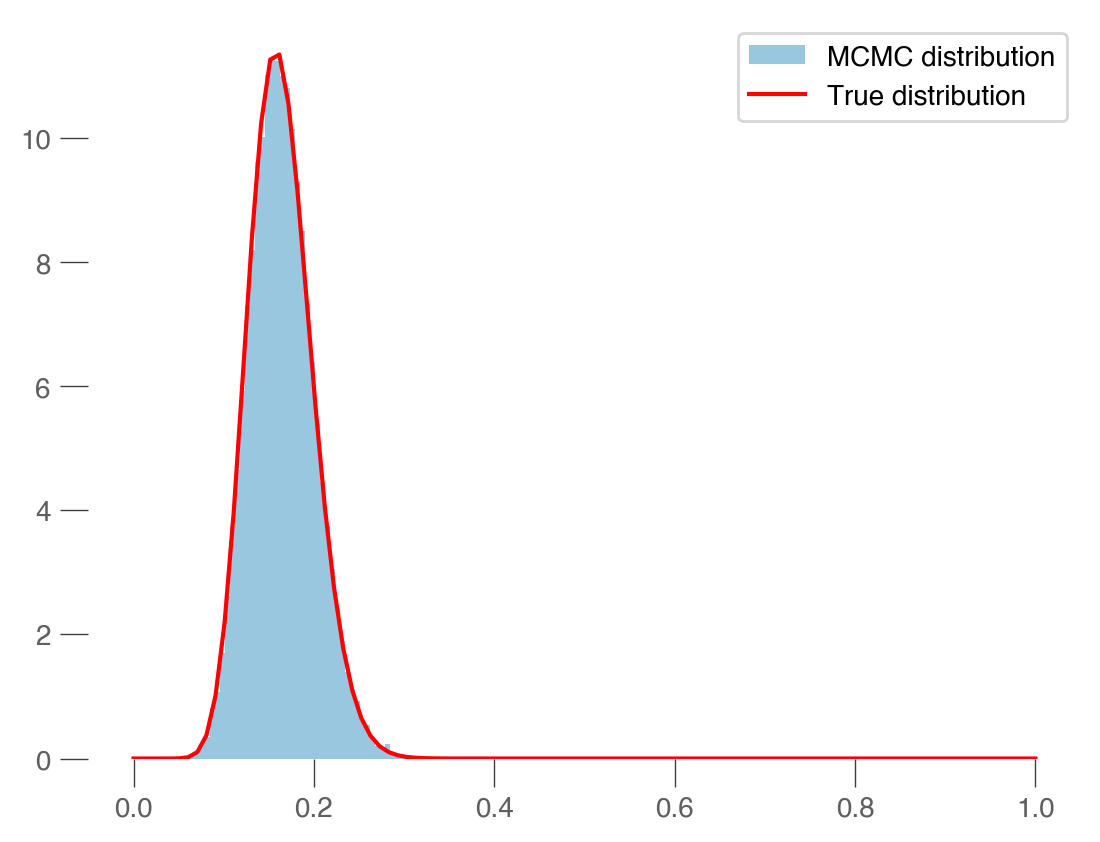

In [28]:
plt.hist(samps, bins=80, alpha=0.4, label="MCMC distribution", density=True)
x = np.linspace(0, 1, 100)
plt.plot(x, stats.beta.pdf(x, 18, 92), "r", label="True distribution")
plt.legend()
plt.show()

Si noti che la procedura di Metropolis genera un insieme di campioni che approssima la distribuzione target desiderata. In altre parole, i campioni ottenuti seguono la distribuzione che stiamo cercando di esplorare, fornendo quindi un modo efficace per ottenere un campionamento casuale da questa distribuzione.

Ora esaminiamo una diversa funzione di proposta: una distribuzione gaussiana centrata attorno allo stato precedente, con una deviazione standard $\sigma$. In questo caso, ogni nuovo punto candidato $x^*$ sarà estratto da una gaussiana con media uguale allo stato corrente $x_{\text{prev}}$ e deviazione standard $\sigma$. Questo introduce un grado di esplorazione randomica attorno al punto attuale, permettendo all'algoritmo di navigare efficacemente nello spazio dei parametri. In pratica, questo significa che, se $\sigma$ è piccola, il valore candidato $x^*$ sarà simile al valore corrente $x_{\text{prev}}$.

In [36]:
# Proposal distribution
def gaussprop(xprev, sigma=0.1):
    return xprev + stats.norm.rvs(scale=sigma)

Applichiamo nuovamente l'algorimo di Metropolis con questa nuova distribuzione proposta.

In [30]:
samps = metropolis_v1(lambda x: stats.beta.pdf(x, 18, 92), gaussprop, n_samples, init_state)
print(samps[0:20])

[0.5        0.36972695 0.24474015 0.24474015 0.24474015 0.20044602
 0.18504543 0.18504543 0.21947944 0.15196794 0.15196794 0.15196794
 0.15196794 0.15196794 0.15196794 0.15196794 0.15358752 0.21559004
 0.13976478 0.13976478]


Otteniamo anche in questo caso un campione casuale dalla distribuzione target.

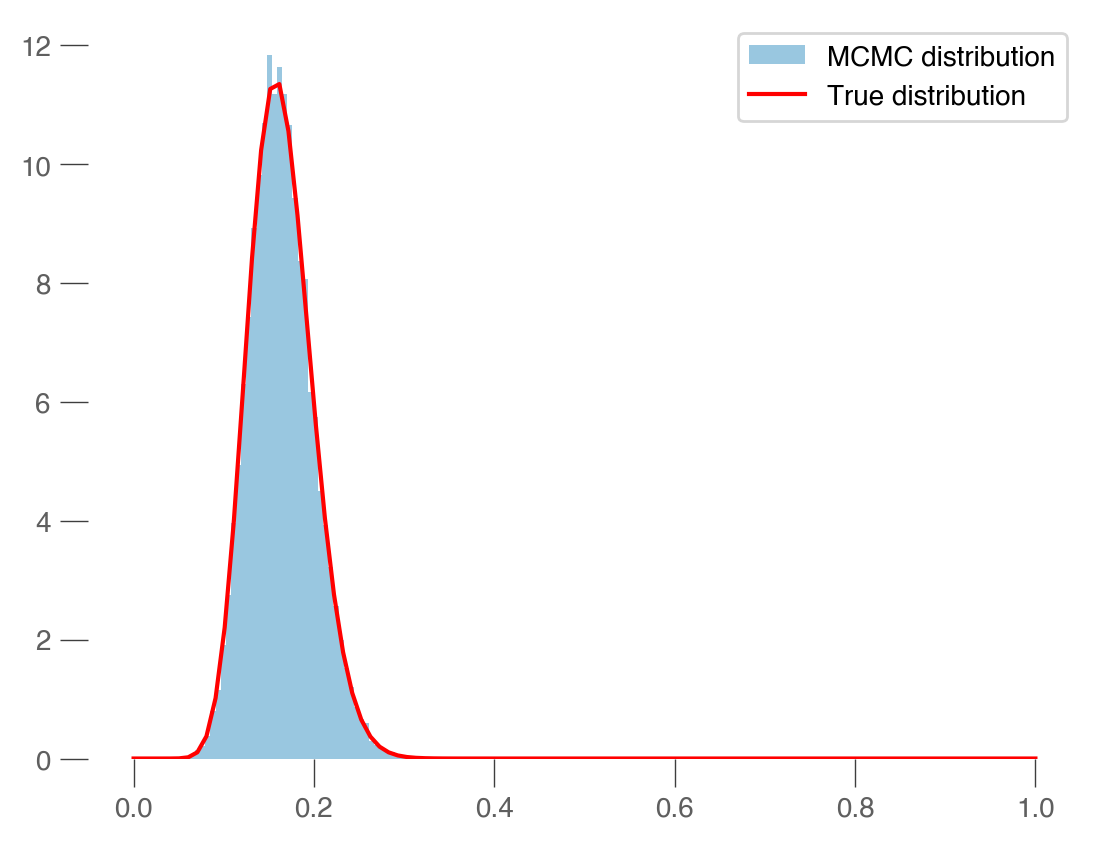

In [31]:
plt.hist(samps, bins=80, alpha=0.4, label="MCMC distribution", density=True)
x = np.linspace(0, 1, 100)
plt.plot(x, stats.beta.pdf(x, 18, 92), "r", label="True distribution")
plt.legend()
plt.show()

### Algoritmo di Metropolis con distribuzione target incognita

Ora andiamo oltre: invece di presupporre che la distribuzione target sia già nota, cosa che si verifica quando utilizziamo distribuzioni coniugate, nel contesto bayesiano la distribuzione target che vogliamo campionare è in realtà il prodotto non normalizzato della verosimiglianza e della distribuzione a priori. 

Iniziamo quindi col definire la distribuzione a priori. In questo esempio, la distribuzione a priori è una distribuzione Beta(2, 10) che è stata scelta solo per motivi didattici e non ha alcuna motivazione ulteriore. 

In [37]:
def prior(p):
    alpha = 4
    beta = 6
    return stats.beta.pdf(p, alpha, beta)

Definiamo la verosimiglianza. Il problema presente richiede una verosimiglianza binomiale.

In [38]:
def likelihood(p):
    y = 14
    n = 100
    return stats.binom.pmf(y, n, p)

La distribuzione a posteriori non normalizzata è il prodotto della distribuzione a priori e della verosimiglianza. Si noti che, per il motivo spiegato prima, non è necessario normalizzare la distribuzione a posteriori.

In [39]:
def posterior(p):
    return likelihood(p) * prior(p)

Per la distribuzione proposta, faremo ricorso alla stessa funzione che abbiamo precedentemente definito. Tuttavia, apporteremo alcune modifiche all'algoritmo di Metropolis per adeguarlo a questo nuovo contesto.

Nell'implementazione di un algoritmo di Metropolis in ambito bayesiano, vi sono diversi aspetti da considerare attentamente. Ecco alcuni punti cruciali:

1. **Simmetria della Distribuzione Proposta**: È fondamentale che la distribuzione proposta sia simmetrica. Questa è una condizione necessaria per il funzionamento dell'algoritmo di Metropolis, ma non per quello di Metropolis-Hastings.
  
2. **Valore Iniziale**: Il valore iniziale scelto dovrebbe essere plausibile in base alla distribuzione a priori, in modo da facilitare la convergenza dell'algoritmo.

3. **Probabilità Zero**: Nel caso in cui la verosimiglianza o il prior assumano un valore di zero, il rapporto tra le densità di probabilità (`pdfratio`) all'interno dell'algoritmo di Metropolis risulterà indefinito. Pertanto, è importante garantire che il valore `x_star`, generato dalla distribuzione proposta, cada sempre entro i limiti del supporto sia del prior che della verosimiglianza.

Di seguito è presentato il codice, rivisto in base a queste considerazioni.

In [40]:
def metropolis_v2(p, qdraw, nsamp, xinit):
    samples = np.empty(nsamp)
    x_prev = xinit
    for i in range(nsamp):
        x_star = qdraw(x_prev)
        # Check that x_star is within the support of the prior and likelihood
        if 0 <= x_star <= 1:
            p_star = p(x_star)
            p_prev = p(x_prev)
            pdfratio = p_star / p_prev if p_prev > 0 else 1

            if np.random.uniform() < min(1, pdfratio):
                samples[i] = x_star
                x_prev = x_star
            else:
                samples[i] = x_prev
        else:
            samples[i] = x_prev  # reject automatically if outside support
    return samples

Le due versioni dell'algoritmo di Metropolis, `metropolis_v1` e `metropolis_v2`, sono simili nella loro struttura di base, ma presentano alcune differenze chiave che riguardano la gestione dei casi speciali:

1. **Controllo del supporto**: Nella versione `metropolis_v2`, c'è un controllo esplicito che assicura che il valore proposto `x_star` cada all'interno del supporto della distribuzione priori e della verosimiglianza (`if 0 <= x_star <= 1`). Se `x_star` è fuori dal supporto, viene automaticamente rifiutato e il campione precedente `x_prev` viene conservato. Questo controllo è assente nella versione `metropolis_v1`.

2. **Gestione delle probabilità zero**: Nella versione `metropolis_v2`, viene effettuato un ulteriore controllo sulla probabilità precedente `p_prev`. Se `p_prev` è zero, `pdfratio` viene impostato automaticamente a 1 (`pdfratio = p_star / p_prev if p_prev > 0 else 1`). Questo gestisce i casi in cui potrebbe verificarsi una divisione per zero. Nella versione `metropolis_v1`, non vi è un controllo simile, e una divisione per zero potrebbe portare a comportamenti indesiderati.

In sintesi, `metropolis_v2` è una versione più robusta dell'algoritmo che tiene conto sia del supporto della distribuzione target sia di eventuali valori zero nella densità di probabilità.  

Si osservi un punto importante: nel calcolo di `pdfratio`, il rapporto tra la densità a posteriori del parametro proposto `x_star` e quella del parametro corrente `x_prev`, la costante di normalizzazione si annulla grazie alla regola di Bayes. Questo lascia nel rapporto solamente le componenti relative alla verosimiglianza e alla distribuzione a priori, che sono entrambe facilmente calcolabili. Matematicamente, questo si esprime come:

$$
\begin{equation}
\text{pdfratio} = \frac{p(\theta^* \mid y)}{p(\theta^{\text{prev}} \mid y)} = \frac{\frac{p(y \mid \theta^*) p(\theta^*)}{p(y)}}{\frac{p(y \mid \theta^{\text{prev}}) p(\theta^{\text{prev}})}{p(y)}}
= \frac{p(y \mid \theta^*) p(\theta^*)}{p(y \mid \theta^{\text{prev}}) p(\theta^{\text{prev}})}
\end{equation}
$$ (eq-ratio-metropolis)

In [41]:
# Perform Metropolis sampling
samps = metropolis_v2(posterior, lambda x: gaussprop(x, sigma=0.05), n_samples, init_state)

In somma, l'algoritmo Metropolis accetta come input il numero `nsamp` di passi da simulare, la deviazione standard $ \sigma $ della distribuzione proposta (in questo esempio, la deviazione standard $\sigma$ è stata scelta empiricamente in modo tale da ottenere un tasso di accettazione adeguato), e la densità a priori. Come output, l'algoritmo restituisce una catena di valori del parametro, specificamente la sequenza $ \theta^{(1)}, \theta^{(2)}, \ldots, \theta^{\text{nsamp}} $. Uno degli aspetti cruciali per la riuscita dell'algoritmo è il raggiungimento della stazionarietà da parte della catena. In genere, i primi 1000-5000 valori vengono scartati in quanto rappresentano il periodo di "burn-in" della catena. Dopo un determinato numero di passi $ k $, la catena converge e i valori diventano campioni effettivi dalla distribuzione a posteriori $ p(\theta \mid y) $.

Il modello descritto è stato inizialmente proposto da Metropolis et al. nel 1953 {cite:t}`metropolist_etal_1953`. Hastings nel 1970 introdusse un'estensione nota come algoritmo Metropolis-Hastings {cite:t}`hastings_1970`. Altre varianti includono il campionatore di Gibbs, introdotto da Geman e Geman nel 1984 {cite}`geman_geman_1984`, l'Hamiltonian Monte Carlo {cite:t}`duane1987hybrid`, e il No-U-Turn Sampler (NUTS) utilizzato in pacchetti come PyMC e Stan {cite:t}`hoffman2014no`. Per un'analisi più dettagliata e intuitiva dell'algoritmo Metropolis, si rimanda a {cite:t}`doing_bayesian_data_an`.

Un elemento chiave da considerare nell'uso dell'algoritmo Metropolis è il tasso di accettazione, che è il rapporto tra il numero di valori del parametro proposti e il numero di quei valori che vengono effettivamente accettati. Un limite di questo algoritmo è la sua inefficienza relativa: rispetto alle sue varianti più moderne, l'algoritmo Metropolis tende ad essere meno efficiente.

## Aspetti computazionali

### Warm-up/Burn-in

Una catena di Markov ha bisogno di alcune iterazioni per raggiungere la distribuzione stazionaria. Queste iterazioni sono comunemente chiamate iterazioni di warm-up o burn-in (a seconda dell'algoritmo e del software utilizzato) e vengono di solito scartate. In molti programmi software, la prima metà delle iterazioni viene considerata come iterazioni di warm-up, quindi, nel caso presente, anche se abbiamo ottenuto 100000 iterazioni, ne utilizzeremo solo 50000.

### Sintesi della distribuzione a posteriori

L'array `samps` contiene 100000 valori di una catena di Markov. Escludiamo i primi 50000 valori considerati come burn-in e consideriamo i restanti 50000 valori come un campione casuale estratto dalla distribuzione a posteriori $p(\theta \mid y)$.

Mediante i valori della catena così ottenuta è facile trovare una stima a posteriori del parametro $\theta$. Per esempio, possiamo trovare la stima della media a posteriori.

In [42]:
burnin = int(n_samples * 0.5)
burnin

50000

In [43]:
np.mean(samps[burnin:])

0.16359791506335483

Oppure possiamo stimare la deviazione standard della distribuzione a posteriori.

In [44]:
np.std(samps[burnin:])

0.03475863351095934

Visualizziamo un *trace plot* dei valori della catena di Markov dopo il periodo di burn-in.

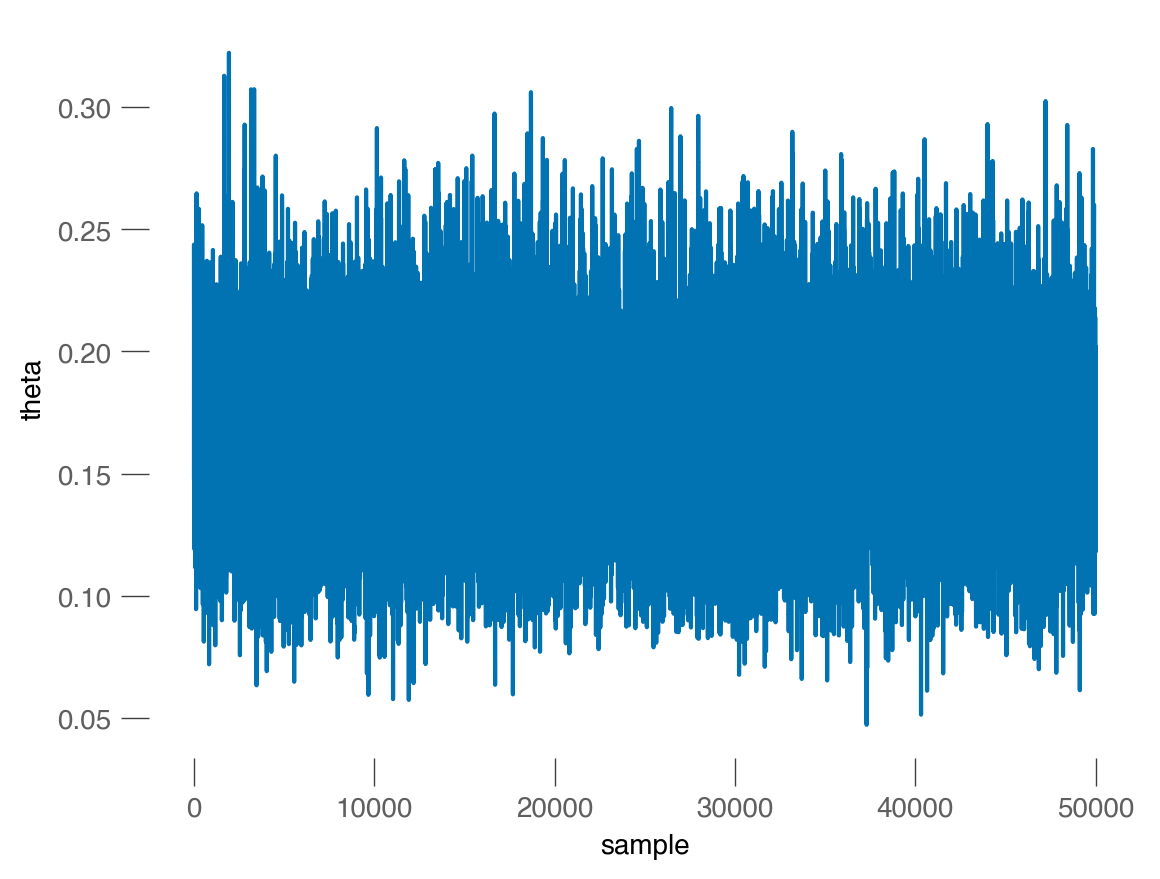

In [45]:
plt.plot(samps[burnin:])
plt.xlabel("sample")
plt.ylabel("theta")
plt.show()

Il trace plot indica che la catena inizia con un valore casuale per poi spostarsi rapidamente nell'area intorno a 0.16, che è l'area con alta densità a posteriori. Successivamente, oscilla intorno a quel valore per le iterazioni successive.

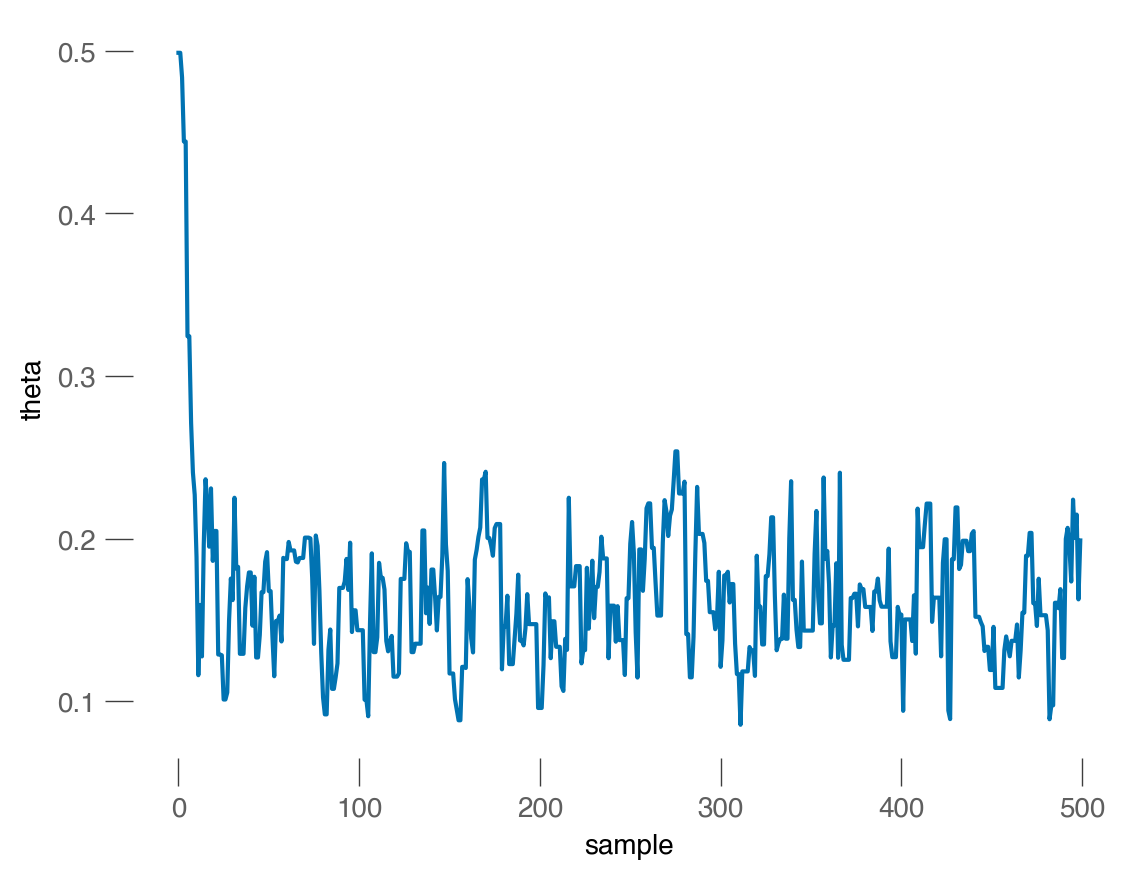

In [46]:
plt.plot(samps[:500])
plt.xlabel("sample")
plt.ylabel("theta")
plt.show()

L'istogramma mostrato di seguito, sul quale è stata sovrapposta la distribuzione a posteriori derivata analiticamente -- specificamente una $\text{Beta}(25, 17)$ -- dimostra che la catena converge effettivamente alla distribuzione a posteriori desiderata.

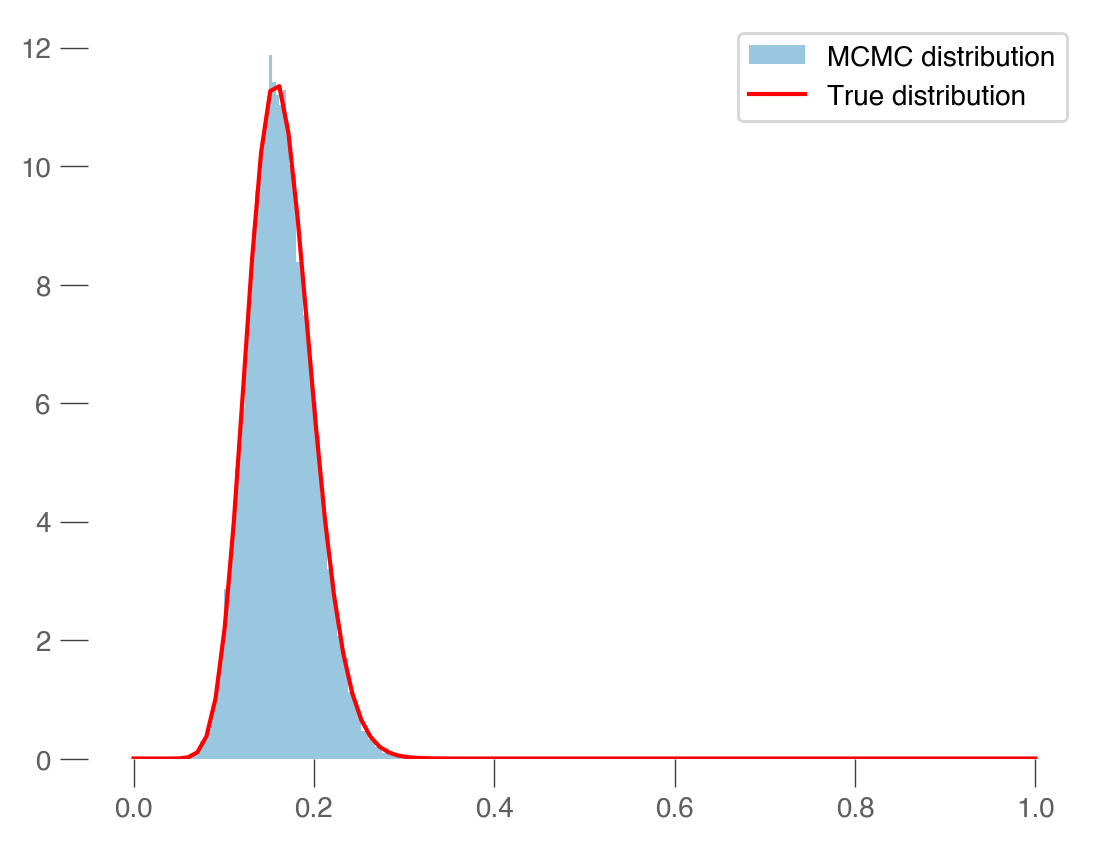

In [24]:
plt.hist(samps[burnin:], bins=80, alpha=0.4, label="MCMC distribution", density=True)
# plot the true function
x = np.linspace(0, 1, 100)
plt.plot(x, stats.beta.pdf(x, 18, 92), "r", label="True distribution")
plt.legend()
plt.show()

È possibile usare la funzione `summary` del pacchetto AriviZ per calolare l'intervallo di credibilità, ovvero l'intervallo che contiene la proporzione indicata dei valori estratti a caso dalla distribuzione a posteriori.

In [25]:
az.summary(samps[burnin:], kind="stats", hdi_prob=0.94, round_to=2)

,mean,sd,hdi_3%,hdi_97%
x,0.16,0.04,0.1,0.23


Un KDE plot corrispondente all'istogramma precedente si può generare usando `az.plot_posterior()`. La curva  rappresenta l'intera distribuzione a posteriori e viene calcolata utilizzando la stima della densità del kernel (KDE) che serve a "lisciare" l'istogramma.

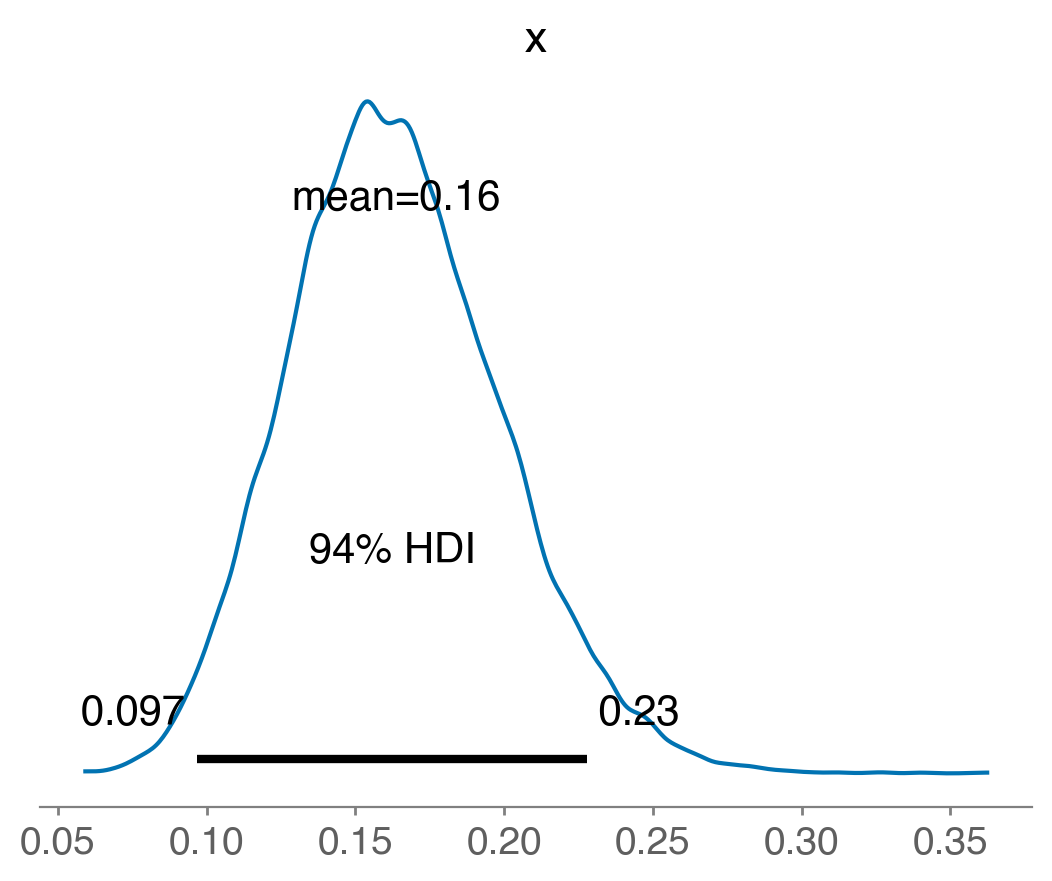

In [26]:
az.plot_posterior(samps[burnin:])
plt.show()

L'HDI è una scelta comune nelle statistiche bayesiane e valori arrotondati come 50% o 95% sono molto popolari. Ma ArviZ utilizza il 94% come valore predefinito. La ragione di questa scelta è che il 94% è vicino al valore ampiamente utilizzato del 95%, ma è anche diverso da questo, così da servire da "amichevole promemoria" che non c'è niente di speciale nella soglia del 5%. Idealmente sarebbe opportuno scegliere un valore che si adatti alle specifiche esigenze dell'analisi statistica che si sta svolgendo, o almeno riconoscere che si sta usando un valore arbitrario.

### Diagnostiche della soluzione MCMC

#### Catene multiple

Poiché ciascuno stato in una catena di Markov dipende dagli stati precedenti, il valore o i valori iniziali possono influenzare i valori campionati. Una soluzione per verificare la sensibilità rispetto ai valori iniziali è utilizzare più catene, ognuna con diversi valori iniziali. Se più catene campionano la stessa distribuzione target, queste dovrebbero mescolarsi bene, ovvero intersecarsi l'una con l'altra in un trace plot.

#### Stazionarietà

Un punto importante da verificare è se il campionatore ha raggiunto la sua distribuzione stazionaria. La convergenza di una catena di Markov alla distribuzione stazionaria viene detta "mixing".

#### Autocorrelazione

Ogni passo nell'algoritmo MCMC è chiamato *iterazione*. I valori campionati sono dipendenti, il che significa che il valore all'iterazione $m$ dipende dal valore all'iterazione $m-1$. Questa è una differenza importante rispetto alle funzioni che generano campioni casuali indipendenti, come `beta(25, 17).rvs()`. I valori campionati formano una *catena di Markov*, il che significa che ciascun valore campionato è correlato con il valore precedente (ad esempio, se $\theta(m)$ è grande, $\theta(m+1)$ sarà anch'esso grande).

Informazioni sul "mixing" della catena di Markov sono fornite dall'autocorrelazione. L'autocorrelazione misura la correlazione tra i valori successivi di una catena di Markov. Il valore $m$-esimo della serie ordinata viene confrontato con un altro valore ritardato di una quantità $k$ (dove $k$ è l'entità del ritardo) per verificare quanto si correli al variare di $k$. L'autocorrelazione di ordine 1 (*lag 1*) misura la correlazione tra valori successivi della catena di Markow (cioè, la correlazione tra $\theta^{(m)}$ e $\theta^{(m-1)}$); l'autocorrelazione di ordine 2 (*lag 2*) misura la correlazione tra valori della catena di Markow separati da due "passi" (cioè, la correlazione tra $\theta^{(m)}$ e $\theta^{(m-2)}$); e così via.

L'autocorrelazione di ordine $k$ è data da $\rho_k$ e può essere stimata come:

$$
\begin{align}
\rho_k &= \frac{Cov(\theta_m, \theta_{m+k})}{Var(\theta_m)}\notag\\
&= \frac{\sum_{m=1}^{n-k}(\theta_m - \bar{\theta})(\theta_{m-k} - \bar{\theta})}{\sum_{m=1}^{n-k}(\theta_m - \bar{\theta})^2} \qquad\text{con }\quad \bar{\theta} = \frac{1}{n}\sum_{m=1}^{n}\theta_m.
\end{align}
$$ (eq-autocor)

Per fare un esempio pratico, simuliamo dei dati autocorrelati.

In [44]:
x = pd.array([22, 24, 25, 25, 28, 29, 34, 37, 40, 44, 51, 48, 47, 50, 51])
print(*x)

22 24 25 25 28 29 34 37 40 44 51 48 47 50 51


L'autocorrelazione di ordine 1 è semplicemente la correlazione tra ciascun elemento e quello successivo nella sequenza.

In [45]:
sm.tsa.acf(x)

array([ 1.        ,  0.83174224,  0.65632458,  0.49105012,  0.27863962,
        0.03102625, -0.16527446, -0.30369928, -0.40095465, -0.45823389,
       -0.45047733, -0.36933174])

Nell'esempio, il vettore `x` è una sequenza temporale di 15 elementi. Il vettore $x'$ include gli elementi con gli indici da 0 a 13 nella sequenza originaria, mentre il vettore $x''$ include gli elementi 1:14. Gli elementi delle coppie ordinate dei due vettori avranno dunque gli indici $(0, 1)$, $(1, 2), (2, 3), \dots (13, 14)$ degli elementi della sequenza originaria. La correlazione di Pearson tra i vettori $x'$ e $x''$ corrisponde all'autocorrelazione di ordine 1 della serie temporale.

Nell'output precedente

-   0.83174224 è l'autocorrelazione di ordine 1 (lag = 1),
-   0.65632458 è l'autocorrelazione di ordine 2 (lag = 2),
-   0.49105012 è l'autocorrelazione di ordine 3 (lag = 3),
-   ecc.

È possibile specificare il numero di ritardi (*lag*) da utilizzare con l'argomento `nlags`:

In [46]:
sm.tsa.acf(x, nlags=4)

array([1.        , 0.83174224, 0.65632458, 0.49105012, 0.27863962])

In Python possiamo creare un grafico della funzione di autocorrelazione (correlogramma) per una serie temporale usando la funzione `tsaplots.plot_acf()` dalla libreria `statsmodels`.

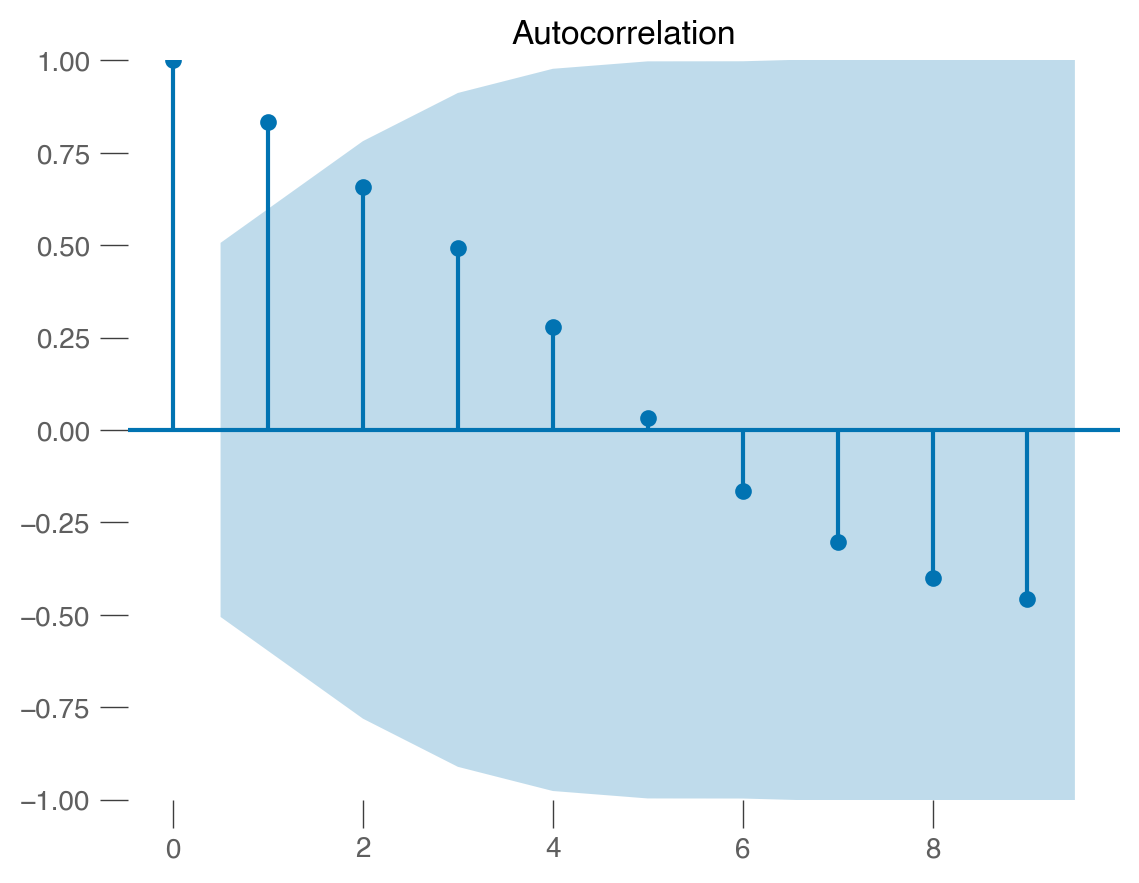

In [47]:
tsaplots.plot_acf(x, lags=9)
plt.show()

Per i dati dell'esempio in discussione otteniamo la situazione seguente.

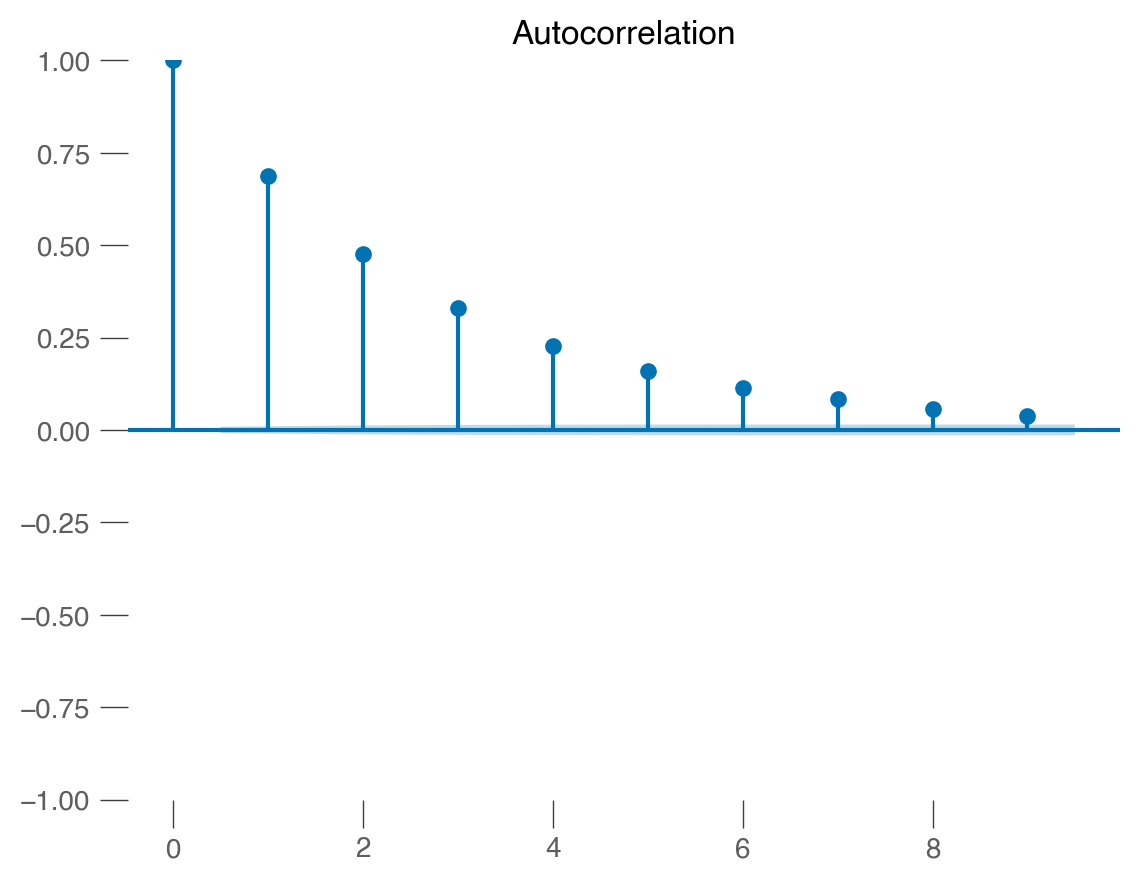

In [47]:
tsaplots.plot_acf(samps[burnin:], lags=9)
plt.show()

Il correlogramma è uno strumento grafico usato per la valutazione della tendenza di una catena di Markov nel tempo. Il correlogramma si costruisce a partire dall'autocorrelazione $\rho_k$ di una catena di Markov in funzione del ritardo $k$ con cui l'autocorrelazione è calcolata: nel grafico ogni barretta verticale riporta il valore dell'autocorrelazione (sull'asse delle ordinate) in funzione del ritardo (sull'asse delle ascisse).

In situazioni ottimali l'autocorrelazione diminuisce rapidamente ed è effettivamente pari a 0 per piccoli lag. Ciò indica che i valori della catena di Markov che si trovano a più di soli pochi passi di distanza gli uni dagli altri non risultano associati tra loro, il che fornisce una conferma del "mixing" della catena di Markov, ossia della convergenza alla distribuzione stazionaria. Nelle analisi bayesiane, una delle strategie che consentono di ridurre l'autocorrelazione è quella di assottigliare l'output immagazzinando solo ogni $m$-esimo punto dopo il periodo di burn-in. Una tale strategia va sotto il nome di *thinning*.

Nel seguente correlogramma, analizziamo la medesima catena di Markov. Tuttavia, in questa occasione applichiamo un "thinning" (sottocampionamento) con un fattore di 5.

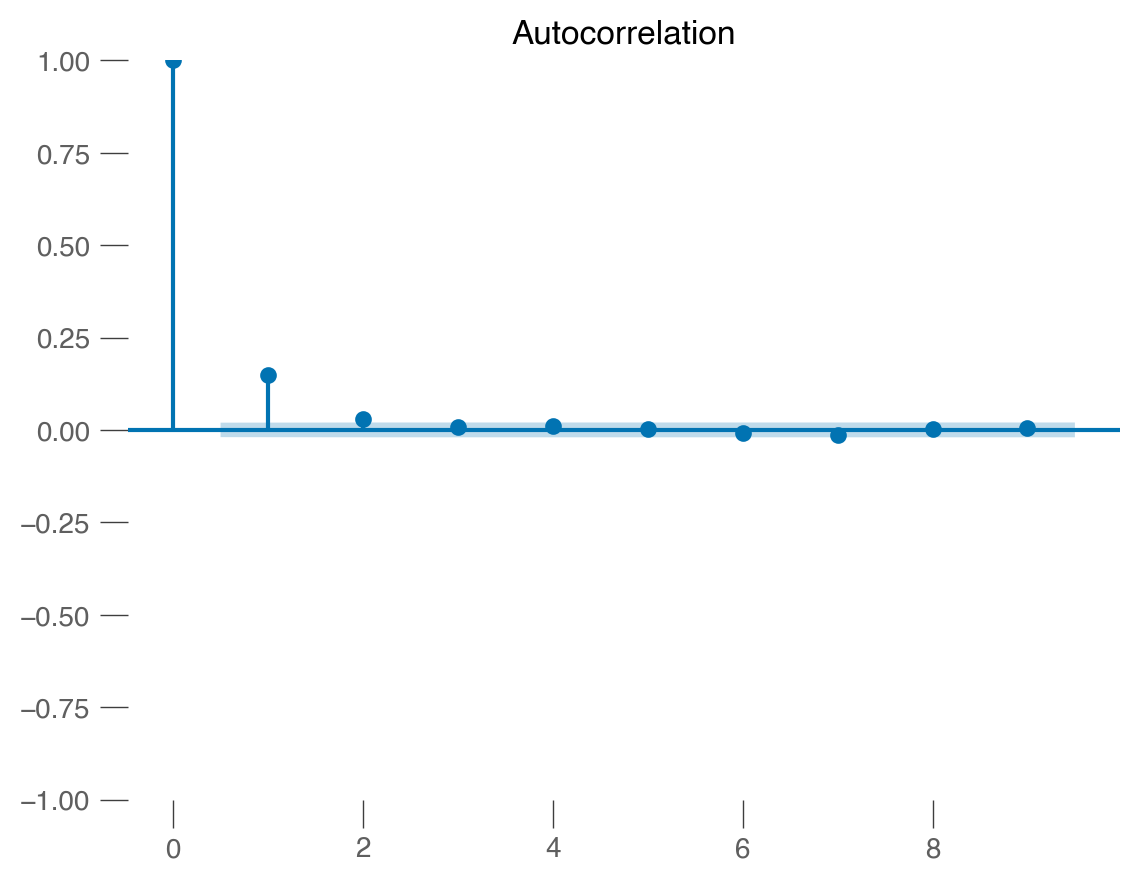

In [48]:
thin=5
sampsthin=samps[burnin::thin]
tsaplots.plot_acf(sampsthin, lags=9)
plt.show()

Si può notare come l'autocorrelazione diminuisce molto più rapidamente.

#### Tasso di accettazione

Quando si utilizza l'algoritmo Metropolis, è importante monitorare il tasso di accettazione e assicurarsi che sia nell'intervallo ottimale. Se si accetta quasi sempre il candidato proposto, probabilmente significa che, in ogni iterazione, la catena salta solo di un piccolo passo (in modo che il rapporto di accettazione sia vicino a 1 ogni volta). Di conseguenza, la catena impiegherà molte iterazioni per raggiungere altre regioni della distribuzione stazionaria e i campioni consecutivi saranno molto fortemente correlati. D'altra parte, se il tasso di accettazione è molto basso, la catena rimarrà bloccata nella stessa posizione per molte iterazioni prima di spostarsi verso uno stato diverso. Per l'algoritmo Metropolis base con un singolo parametro con una distribuzione proposta Gaussiana normale, un tasso di accettazione ottimale è compreso tra il 40% e il 50%.

#### Test di convergenza

Un test di convergenza può essere svolto in maniera grafica mediante le tracce delle serie temporali (*trace plot*), cioè il grafico dei valori simulati rispetto al numero di iterazioni. Se la catena è in uno stato stazionario le tracce mostrano assenza di periodicità nel tempo e ampiezza costante, senza tendenze visibili o andamenti degni di nota. 

Ci sono inoltre alcuni test che permettono di verificare la stazionarietà del campionatore dopo un dato punto. Uno è il test di Geweke che suddivide il campione, dopo aver rimosso un periodo di burn in, in due parti. Se la catena è in uno stato stazionario, le medie dei due campioni dovrebbero essere uguali. Un test modificato, chiamato Geweke z-score, utilizza un test $z$ per confrontare i due subcampioni ed il risultante test statistico, se ad esempio è più alto di 2, indica che la media della serie sta ancora muovendosi da un punto ad un altro e quindi è necessario un periodo di burn-in più lungo.

#### Effective sample size (ESS)

Quando le iterazioni sono dipendenti, ogni iterazione contiene informazioni sovrapposte con le iterazioni precedenti. In altre parole, quando si ottengono 500 campioni dipendenti dalla distribuzione a posteriori, questi contengono solo informazioni equivalenti a < 500 campioni indipendenti. L'ESS (Effective Sample Size) quantifica la quantità effettiva di informazioni, quindi una catena con ESS = n conterrà approssimativamente la stessa quantità di informazioni di n campioni indipendenti. In generale, vogliamo che l'ESS sia almeno 400 per un'utilizzazione generale nel riassumere la distribuzione a posteriori.

## Commenti e considerazioni finali 

In generale, la distribuzione a posteriori dei parametri di un modello statistico non può essere determinata per via analitica. Tale problema viene invece affrontato facendo ricorso ad una classe di algoritmi per il campionamento da distribuzioni di probabilità che sono estremamente onerosi dal punto di vista computazionale e che possono essere utilizzati nelle applicazioni pratiche solo grazie alla potenza di calcolo dei moderni computer. Lo sviluppo di software che rendono sempre più semplice l'uso dei metodi MCMC, insieme all'incremento della potenza di calcolo dei computer, ha contribuito a rendere sempre più popolare il metodo dell'inferenza bayesiana che, in questo modo, può essere estesa a problemi di qualunque grado di complessità.

## Watermark

In [28]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sun Sep 03 2023

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.15.0

pandas     : 2.1.0
scipy      : 1.11.2
arviz      : 0.16.1
numpy      : 1.25.2
seaborn    : 0.12.2
statsmodels: 0.14.0
matplotlib : 3.7.2

Watermark: 2.4.3

